a system is **critical** if it is in transition between two phases.  water at its freezing point is a critical system.
* long tailed distributions of some physical quantities.  eg. crystal sizes are a power law
* Fractal Geometries
* variations in time that exhibit pink noise--"noise" is a time series with many frequency components.  In white noise all frequencies have equal power.  In pink noise, low-frequency components have more power than high-frequency.  Power at frequency f is proportional to 1/f.
* unstable.  small changes tend to change state of system.

Many natural systems exhibit criticality, but if unstable, why?

SOC means that, from any initial condition, the system tends toward a critical state and stay there without external control.


##Exercise 9.1 - Sand Pile
[paper link](http://cqb.pku.edu.cn/tanglab/pdf/1987-63.pdf)
* 2d cellular automaton where state of each cell represents slope of sand pile.  edges have slope 0.
* at each time step, cell is cehcked to see if it exceeds some critical value, K.  If so, "avalanche" occurs
    1. cell's slope is decreased by 4 and each neighbor is increased by 1
* initialize with some z > K for all and let evolve untill stabilizes.
* to observe effect of small perturbations:
    1. choose cell at random and increment its value by 1
    2. evolve system again until stabilizes
    3. measure D - the total number of cells affected by the resulting avalanche.
* distribution of D should be long-tailed.

In [6]:
%pylab inline
from Life import *
import thinkstats, thinkplot

Populating the interactive namespace from numpy and matplotlib


In [3]:

class SandPile(Life):
    
    def __init__(self, k=4, n=10):
        self.n = n
        self.k = k
        self.array = np.zeros((n,n), dtype=np.int)
        a = np.full((n-2,n-2), k, dtype=np.int)
        self.array[1:n-1,1:n-1] = a
        
    def neighbors(self, row, col):
        if row == 0 and col==0:
            return [(row+1, col),
                    (row, col+1)]
        elif row == 0:
            return [(row+1, col),
                    (row, col+1),
                    (row, col-1)]
        elif col == 0:
            return [(row+1, col),
                    (row, col+1),
                    (row-1, col)]
        else:
            return [(row+1, col),
                    (row, col+1),
                    (row-1, col),
                    (row, col-1)]
        
        
    def step(self):
        a = np.copy(self.array)
        
        for row in xrange(self.n):
            for col in xrange(self.n):
                z = self.array[row, col]
                if z >= 4:
                    a[row, col] -= 4
                    for cell in self.neighbors(row, col):
                        try: a[cell] += 1
                        except IndexError: pass
        self.array = a
    
    def seed(self):
        seed = tuple(np.random.randint(self.n, size=2))
        self.array[seed] += 1
        
    def disturb(self, seed='random'):
        """
        seed is either random, or a tuple (row, col)"""
        previous =  self.array.copy()
        if seed=='random':
            seed = tuple(np.random.randint(self.n, size=2))
        self.array[seed] += 1

        completion_steps = self.stabilize()
        cluster_size = np.sum(previous != self.array)
        return cluster_size, completion_steps
        
    
    def stabilize(self):
        i = 0
        while True:
            previous = self.array
            self.step()
            i+=1
            if np.all(previous == self.array) and i>0:
                break
        return i
    
    def is_stable(self):
        return np.all(self.array<4)



NameError: name 'Life' is not defined

672 steps to initially stabilize


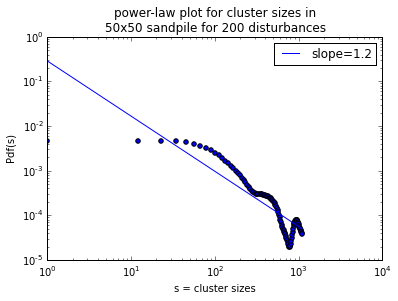

In [167]:
def fit(xs, ys):
    log_xs = np.log10(xs)
    log_ys = np.log10(ys)
    while True:
        if np.all(np.isfinite(log_xs)) and \
                np.all(np.isfinite(log_ys)):
            break
        log_ys = np.delete(log_ys, -1)
        log_xs = np.delete(log_xs, -1)
    p = np.polyfit(log_xs, log_ys, 1)
    
    fit_ys = [np.power(x,p[0])*np.power(10,p[1]) for x in xs]
    return p, xs, fit_ys

def plot_cluster_sizes(n=50, ntrials=100, plot=True):
    sp = SandPile(n=n)
    print sp.stabilize(), 'steps to initially stabilize'
    sizes = []
    for i in range(ntrials):
        size, _ = sp.disturb()
        sizes.append(size)
    cdf = thinkstats.EstimatedPdf(sizes)
    sizes, probs = zip(*cdf.Items())
    poly, fitted_sizes, fitted_probs = fit(sizes, probs)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(fitted_sizes, fitted_probs, label='slope=%.2g'%(-poly[0]))
        ax.scatter(sizes, probs)
#         thinkplot.Pmf(cdf)
        ax.legend(loc='best')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Pdf(s)')
        ax.set_xlabel('s = cluster sizes')
        ax.set_title('power-law plot for cluster sizes in\n'+
                     '%dx%d sandpile for %d disturbances'%(n,n,ntrials))
        
    return cdf, poly
plot_cluster_sizes(n=50, ntrials=200)
# plot_cluster_sizes(ntrials=100)
# plot_cluster_sizes(ntrials=200)
plt.show()

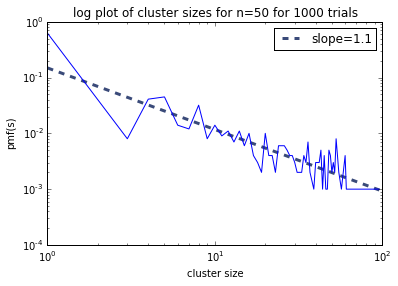

In [206]:
import thinkplot
def plot_ccdf_log_log(cdf, ax=None, label=''):
    values, probs = zip(*cdf.Items())
    ys = np.cumsum(probs)
#     ys = [1.0-p for p in probs]
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(values, ys, label=label)
    ax.set_yscale('log')
    ax.set_xscale('log')
    return ax

n = 50
ntrials = 1000
sand = SandPile(n)
res = [sand.disturb()[0] for i in xrange(ntrials)]
cdf = thinkstats.Pmf(res)
xs, ys = zip(*cdf.Items())
p, fit_xs, fit_ys = fit(xs, ys)
thinkplot.plot(fit_xs,fit_ys, linestyle='--', label='slope=%.2g'%(-p[0]))
plt.plot(xs, ys)
thinkplot.Config(xscale='log',
                 yscale='log',
                 title='log plot of cluster sizes for n=50 for 1000 trials',
                 xlabel='cluster size',
                 ylabel="pmf(s)")
thinkplot.Show()

False
starting animation



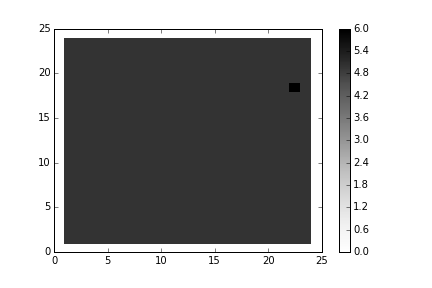
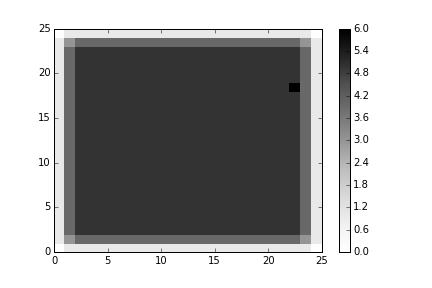
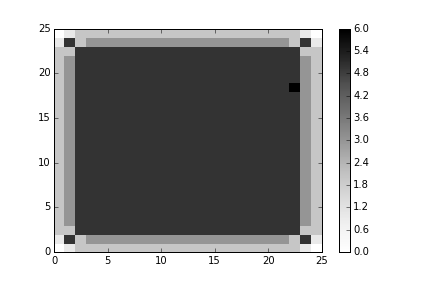
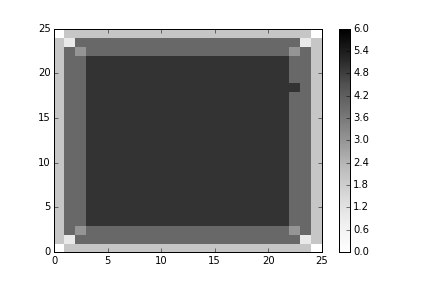
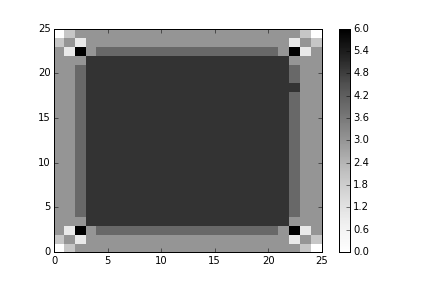
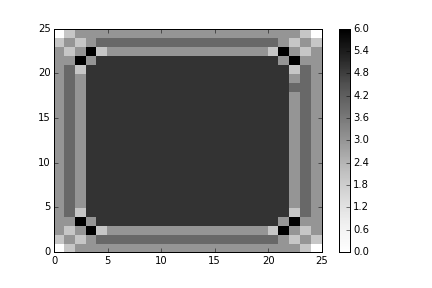
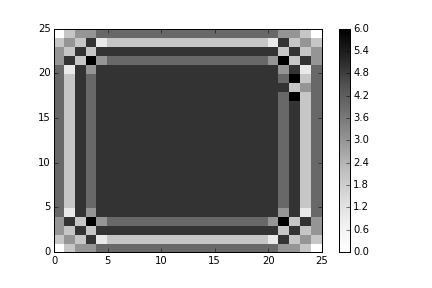
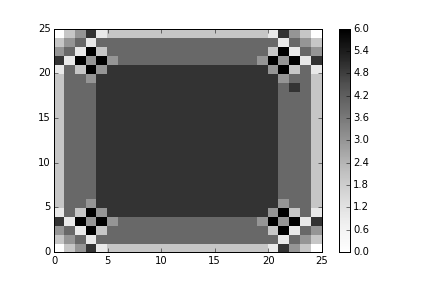
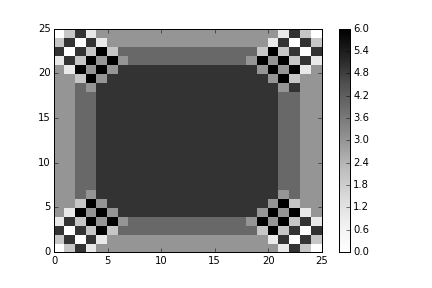
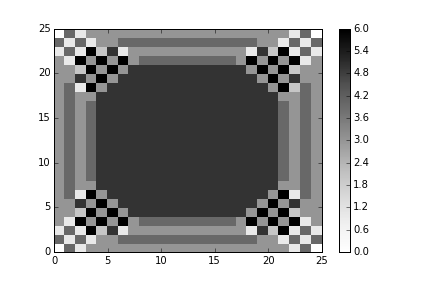
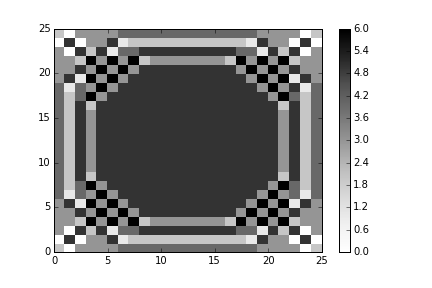
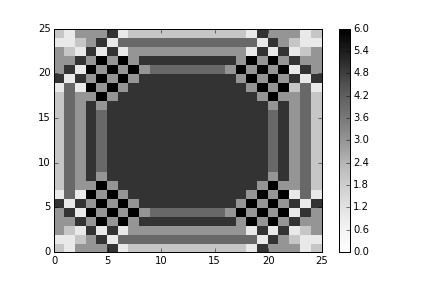
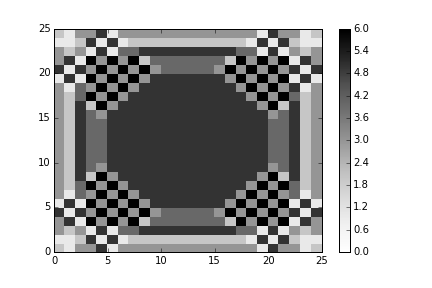
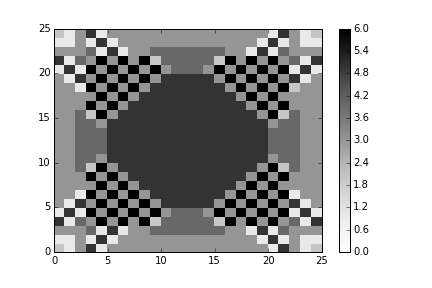
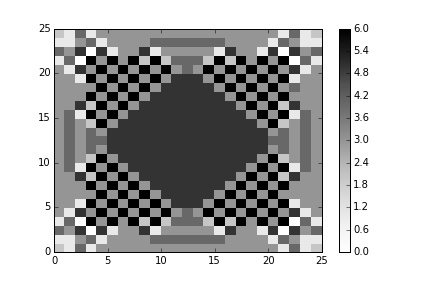
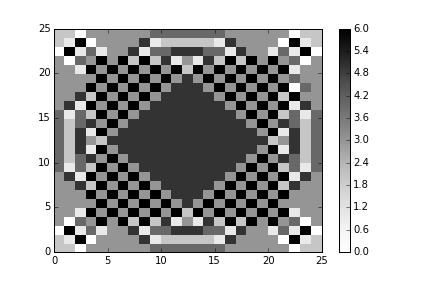
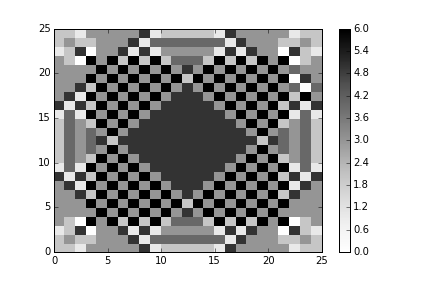
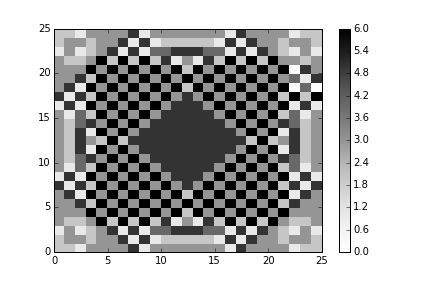
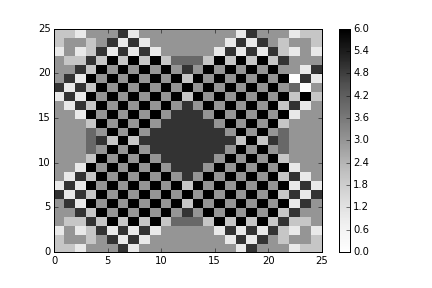
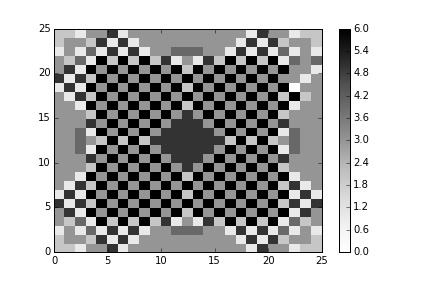
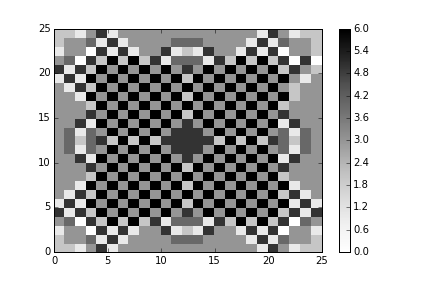
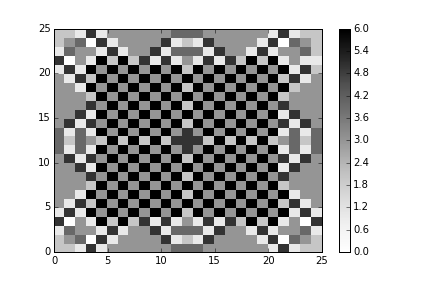
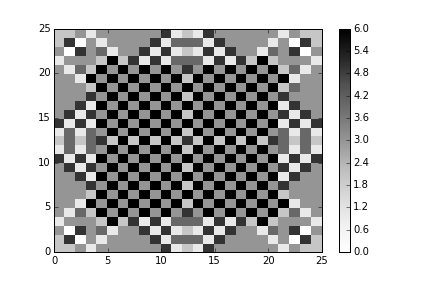
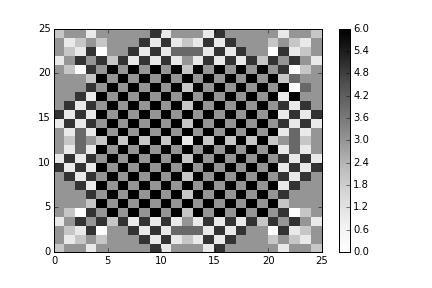
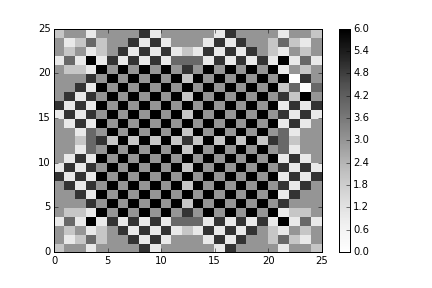
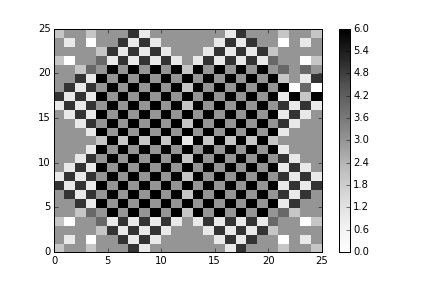
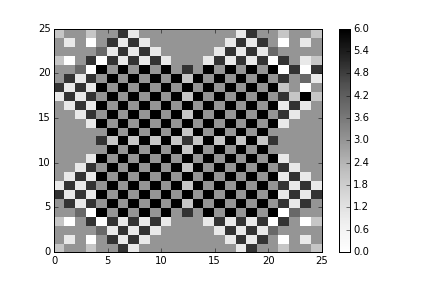
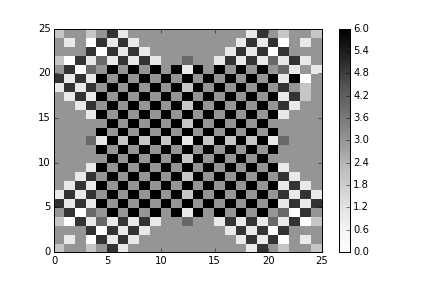
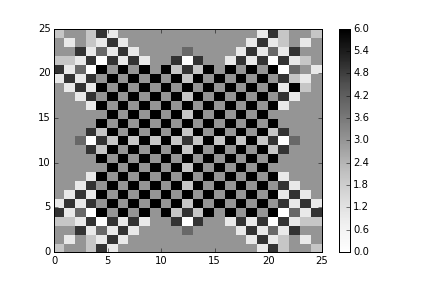
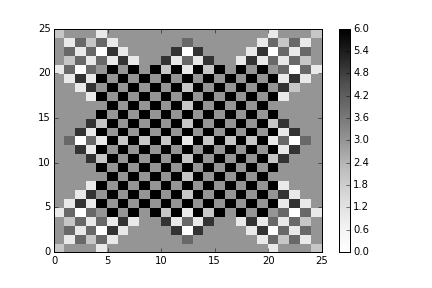
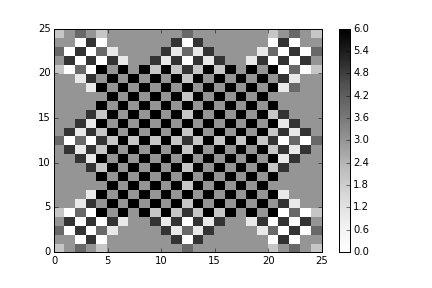
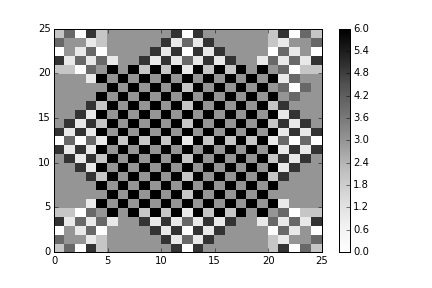
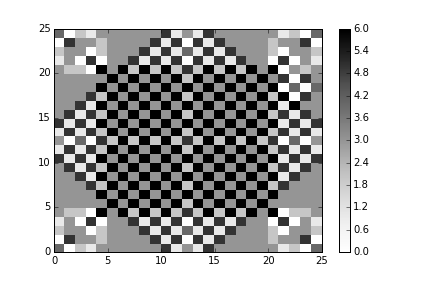
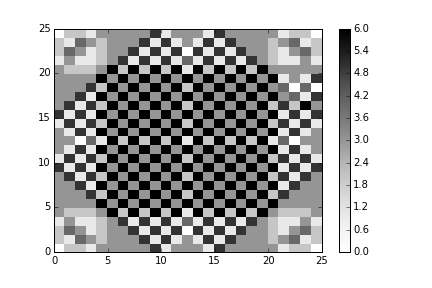
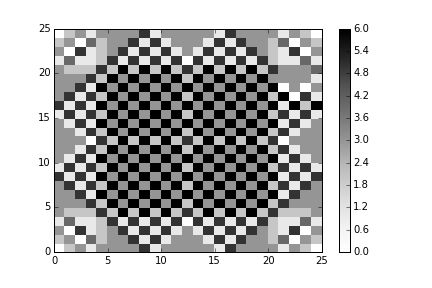
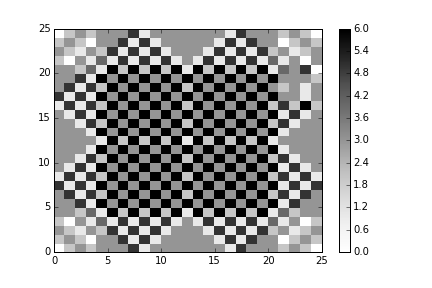
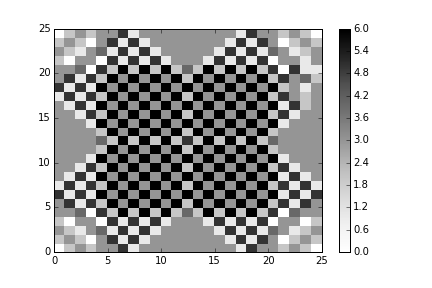
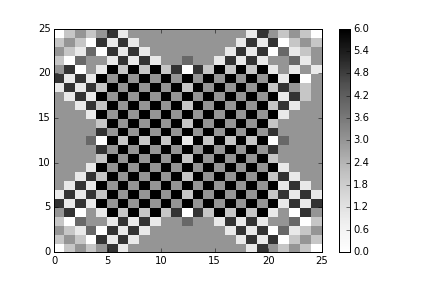
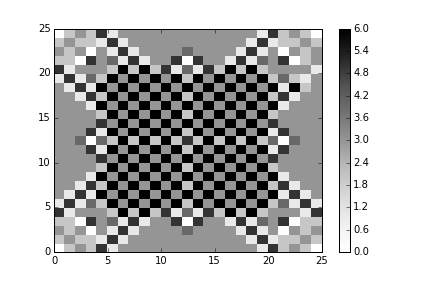
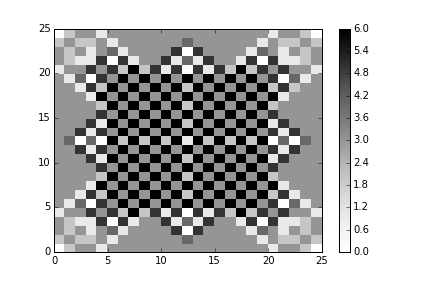
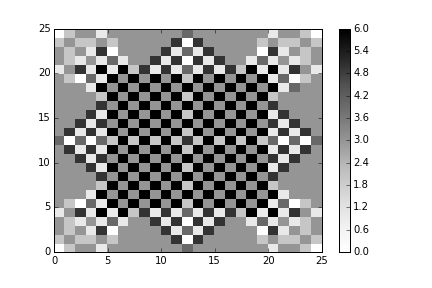
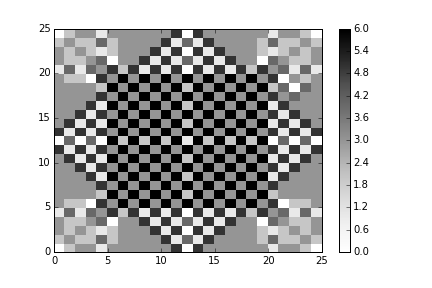
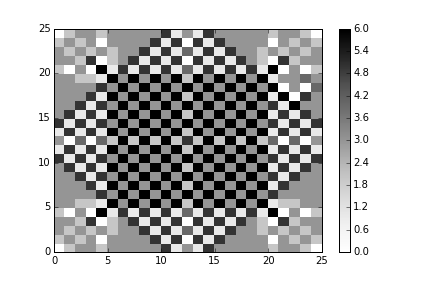
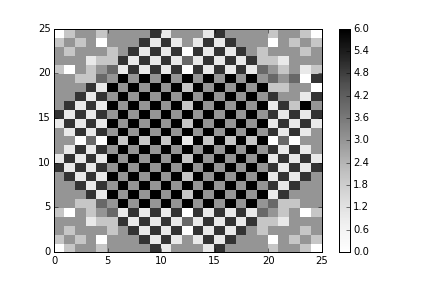
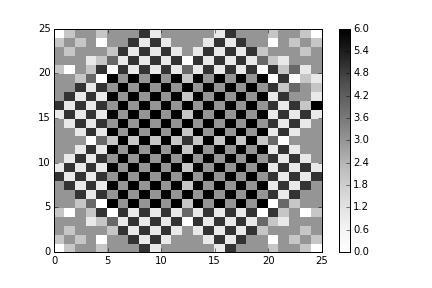
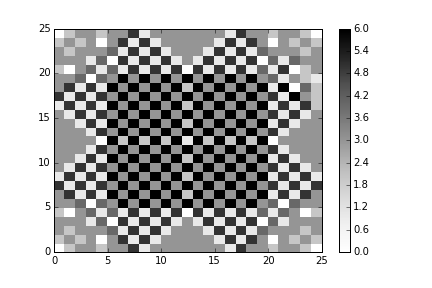
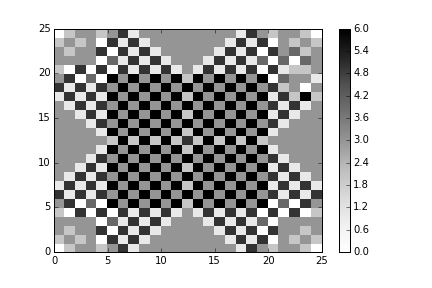
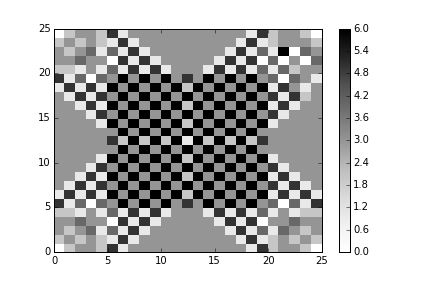
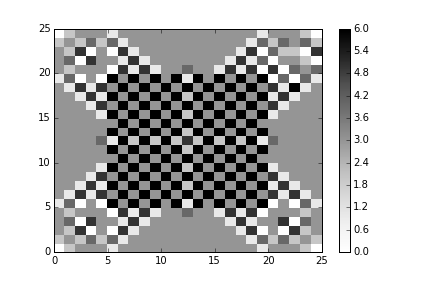
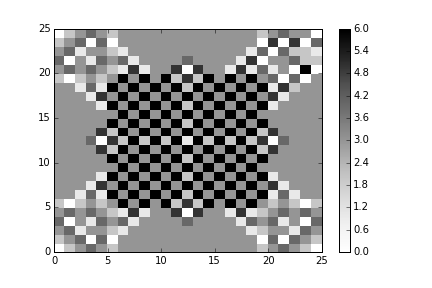
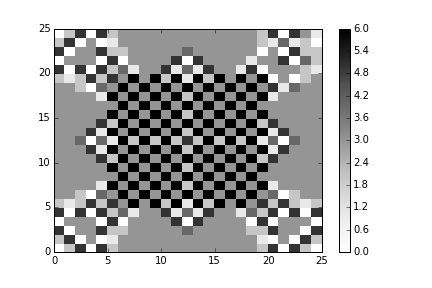
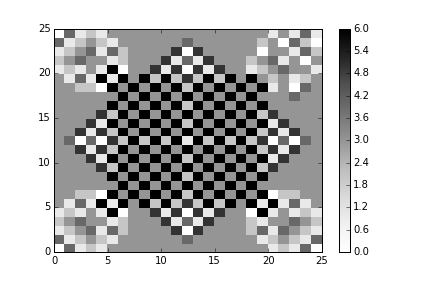
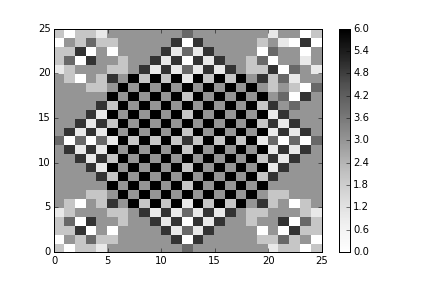
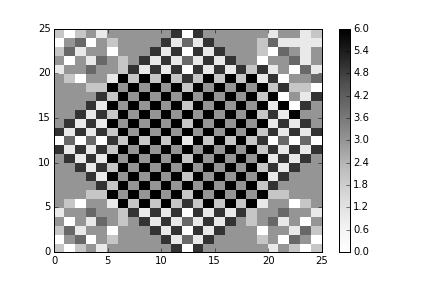
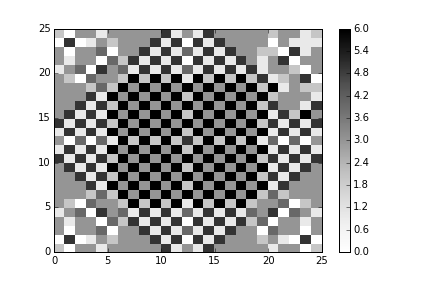
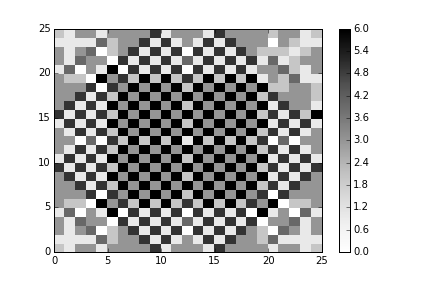
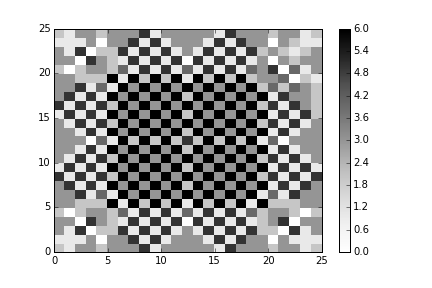
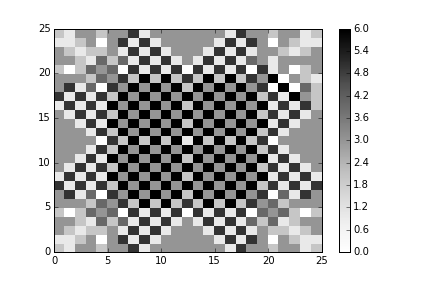
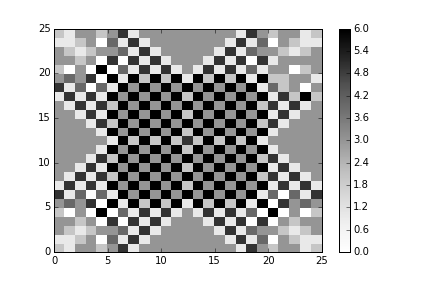
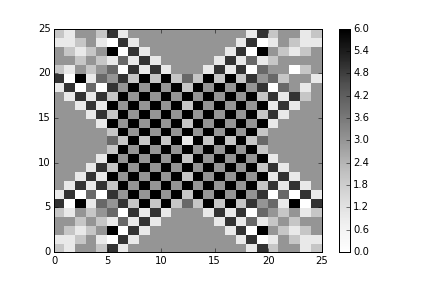
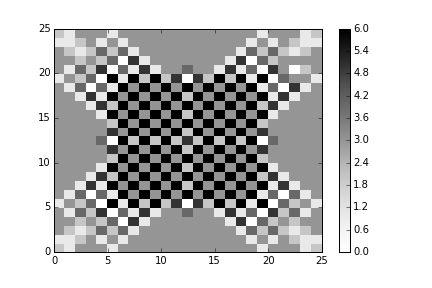
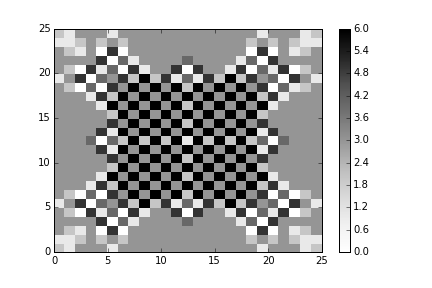
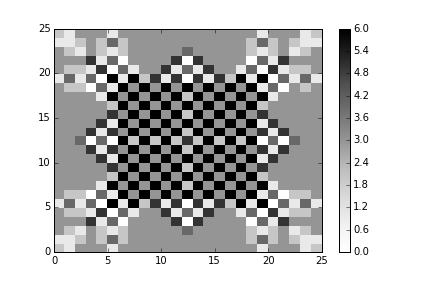
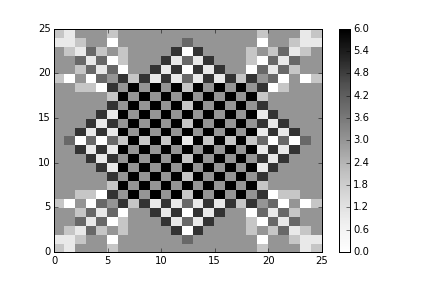
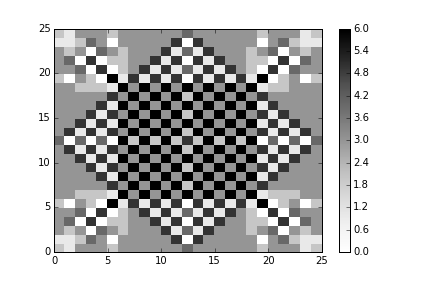
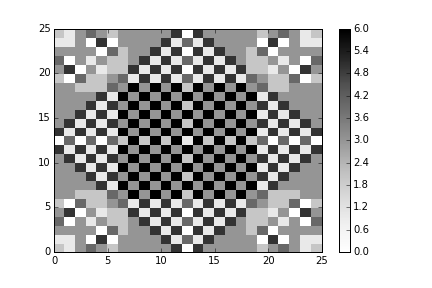
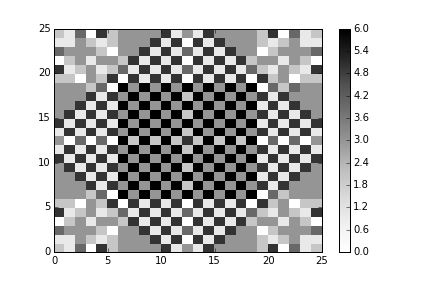
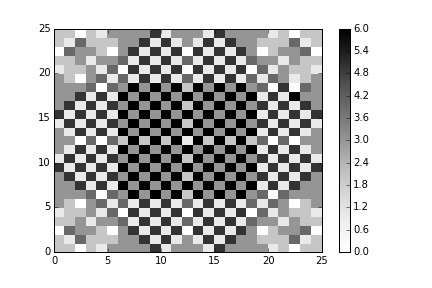
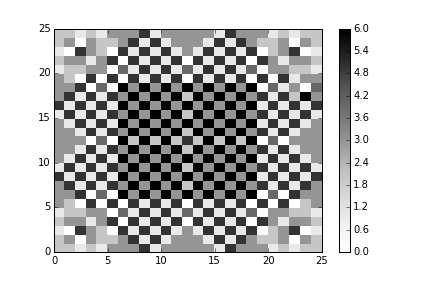
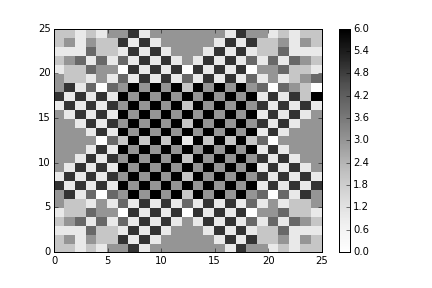
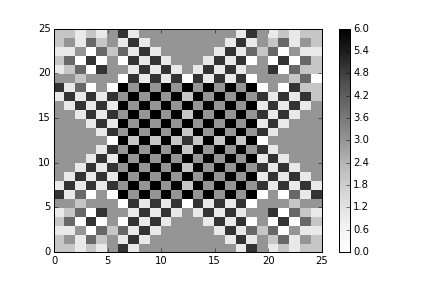
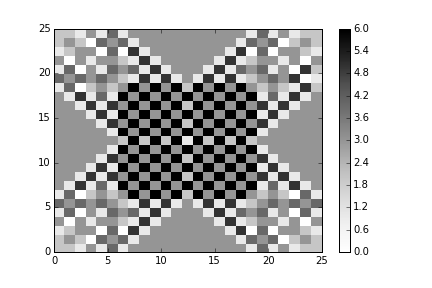
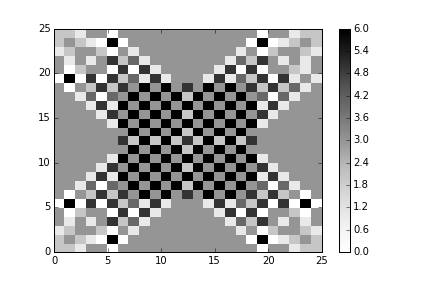
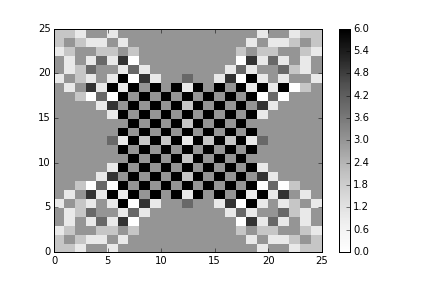
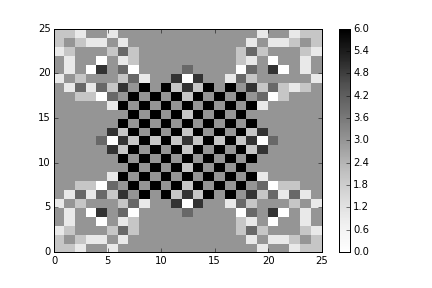
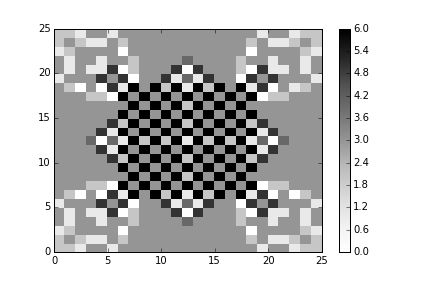
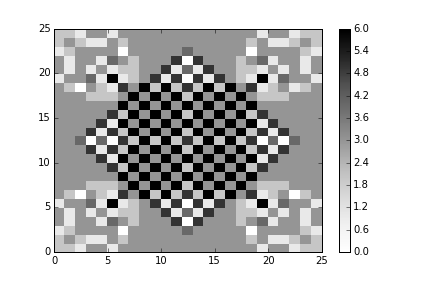
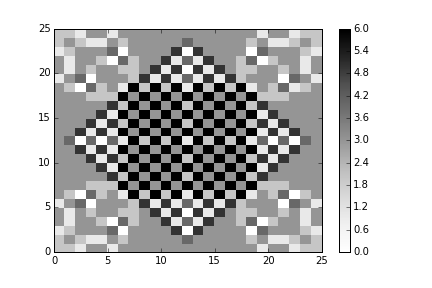
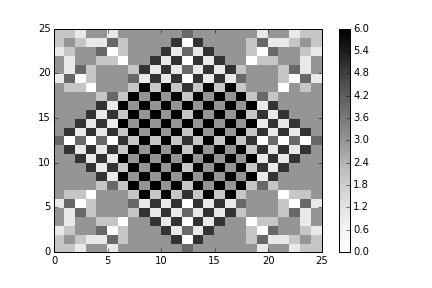
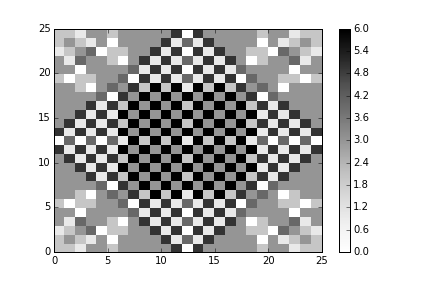
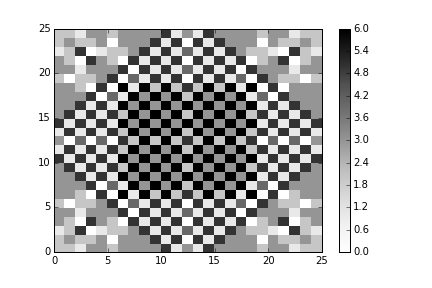
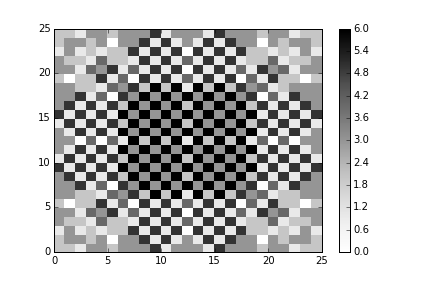
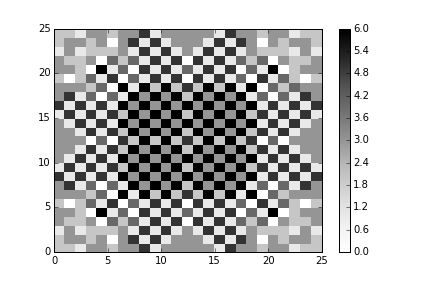
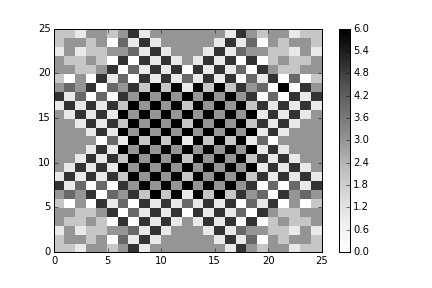
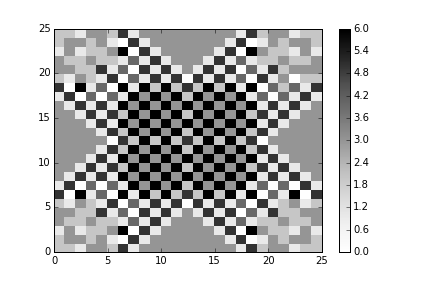
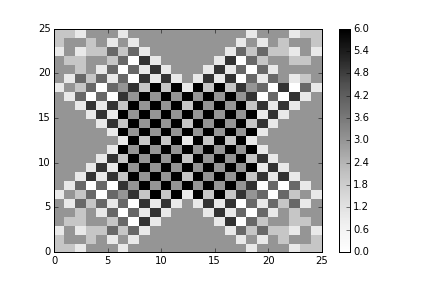
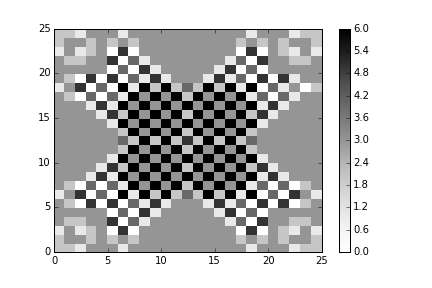
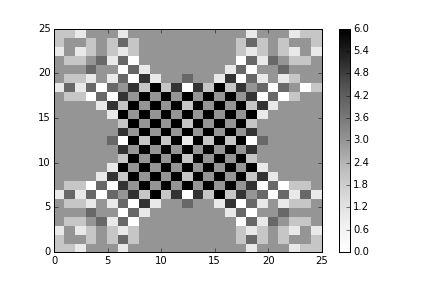
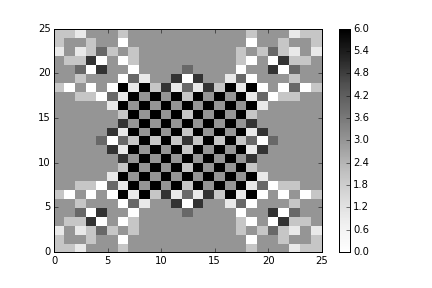
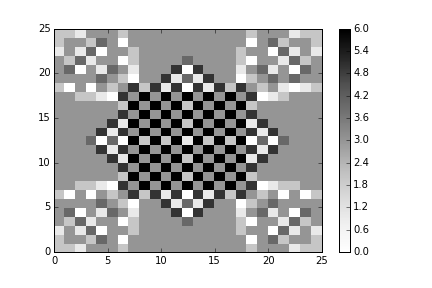
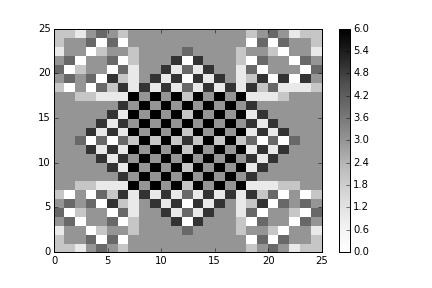
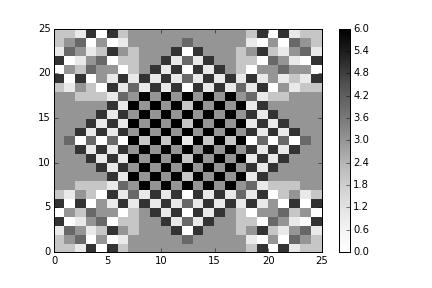
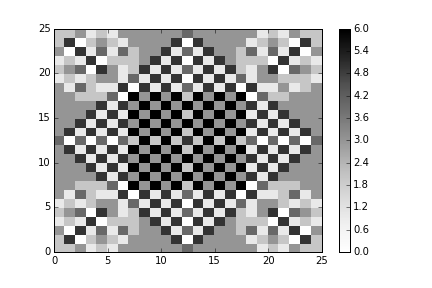
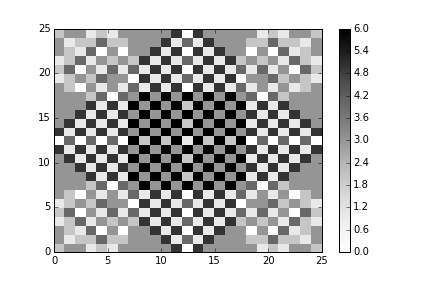
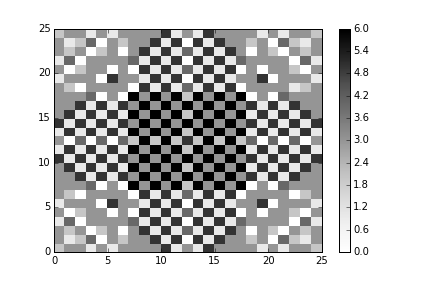
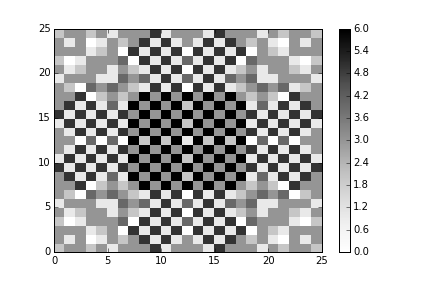
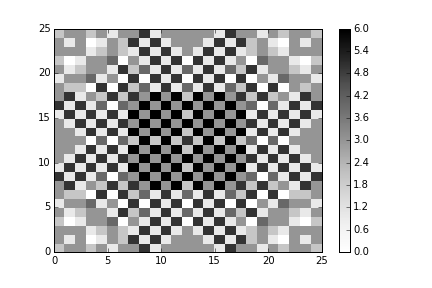
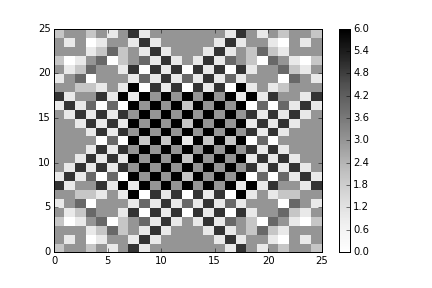
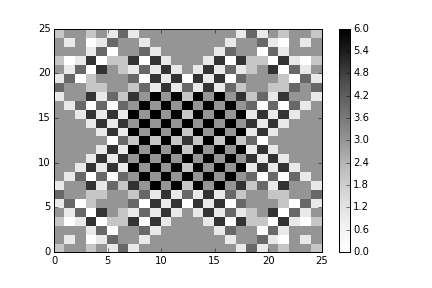
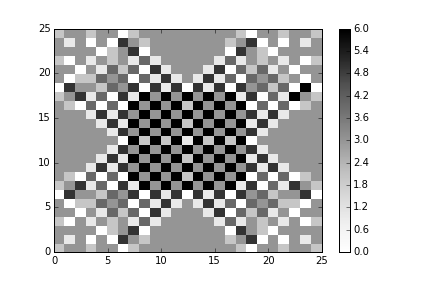

In [318]:
class SandViewer(object):
    def __init__(self, sand, interval=200, cmap=matplotlib.cm.Greys):    
        self.cmap = cmap
        self.interval = interval
        self.sand = sand
        
    def frame_generator(self):
        counter=0
        while not self.sand.is_stable():
            yield self.i
            self.i += 1
            
    
    def seed_frame_generator(self, seeds=10):
        for s in xrange(seeds):
            iter = self.frame_generator()
            if self.i>0:
                self.sand.seed()
                print "seeded", self.i
            counter = 0
            while True:
                try:
                    nxt = iter.next()
                    print 'nxt', nxt, self.i
                    yield nxt
                except StopIteration:
                    print "got stop",nxt
                    break
            print 'seed',s,'i=',self.i
            
    def run(self, steps=50):
        from matplotlib import animation
        from JSAnimation import IPython_display
        from JSAnimation import HTMLWriter
        if steps=="complete":
            steps=self.frame_generator()
        if steps=='seed':
            steps=self.seed_frame_generator()
        self.steps = steps
        
        self.fig = plt.figure()
        self.ax = plt.axes()
        a = self.sand.array
        self.mesh = self.ax.pcolormesh(a, cmap=self.cmap)
        anim = animation.FuncAnimation(self.fig,
                                       self.animate,
                                       init_func=self.init,
                                       frames=self.steps, 
                                       interval=self.interval, 
                                       blit=False)
        return anim
    
    def init(self, verbose=True):
        self.i = 0
        if verbose: print "starting animation"
        a = self.sand.array
        self.mesh = self.ax.pcolormesh(a, cmap=self.cmap,
                                       vmin=0, vmax=self.sand.k + 1)
        self.fig.colorbar(self.mesh)
        return self.mesh, 
    
    def animate(self, i ):
        if i > 0:
            self.sand.step()
        a = self.sand.array
#         self.mesh = self.ax.pcolormesh(a, cmap=self.cmap)
        self.mesh.set_array(a.ravel())
        return self.mesh,

# sand = SandPile(n=50, k=8)
# for i in range(500):
#     sand.disturb()
# sand.stabilize()
sand2 = SandPile(n=25, k=5)
sand2.seed()
sv = SandViewer(sand2)
# print sand2.is_stable()
sv.run('complete')


In [1]:
def fit_D2(inv_Es, Ns):
    """optimized to get rid of log0s"""
    inv_Es = inv_Es[:]
    Ns = Ns[:]
    assert len(inv_Es) == len(Ns)
    
    while True:
        try:
            if len(Ns) == 0:
                raise ValueError('could not fit')
            x = np.log10(inv_Es)
            y = np.log10(Ns)
        except:
            inv_Es.pop(0)
            Ns.pop(0)
            continue
        
        if np.all(np.isfinite(x)) and np.all(np.isfinite(y)):
            break
        inv_Es.pop(0)
        Ns.pop(0)
          
    z = np.polyfit(x, y, 1)
    return z, inv_Es, np.power(inv_Es, z[0]) *np.power(10, z[1])

def calculate_fractal_dimension(a, title=''):
    """currently only works for square arrays, a"""
    from collections import deque
    height, width = a.shape

    #side lengths:
    side_lengths = deque()
    sl = 1
    while sl <= width:
        if width%sl==0:
            side_lengths.appendleft(sl)
        sl+=1
    inv_Es = [1.0/s for s in side_lengths]

    #Ns
    Ns = []
    for sl in side_lengths:
        N = 0
        for row in xrange(height):
            for col in xrange(width):
                if col % width == 0: continue #end
                if col % sl != 0: continue
                test = np.sum(a[row:row+sl, col:col+sl]) >= sl**2/2
                N += test
        Ns.append(N)
    
    z, fit_xs, fit_ys = fit_D2(inv_Es, Ns)
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(inv_Es, Ns)
        ax.plot(fit_xs, fit_ys, label='D=%g'%z[0])
        ax.set_yscale('log')
        ax.set_ylabel('$N(\epsilon)$')
        ax.set_xscale('log')
        ax.set_xlabel('$1/\epsilon$')
        ax.set_title('Fractal Dimension Plot: %s'%title)
        ax.legend(loc='best')
    return z[0]
sfc = SandFractalCalculator(sand) 
sfc.calculate()


NameError: name 'SandFractalCalculator' is not defined

In [2]:
class SandFractalCalculator(object):
    
    def __init__(self, sand):
        self.sand =  sand
        self.get_minimally_stable()
    
    def get_minimally_stable(self):
        sand_array = self.sand.array
        a = np.zeros(sand.array.shape)
        
        for row in xrange(self.sand.n):
            for col in xrange(self.sand.n):
                neighbors = self.sand.neighbors(row, col)
                for n in neighbors:
                    try: 
                        if sand_array[n] >= 3: a[row,col] = 1
                    except IndexError: pass #neighbors returns cells not in array
        self.array = a
        
    def show(self):
        print self.array
        fig, ax = plt.subplots()
        ax.pcolormesh(self.array, cmap=matplotlib.cm.Greys)
        plt.show()
        
    def calculate(self):
        calculate_fractal_dimension(self.array)

                    
for i in xrange(10000):
    sand.disturb()
sfc = SandFractalCalculator(sand) 
sfc.show()
sfc.calculate()



NameError: name 'sand' is not defined

starting animation



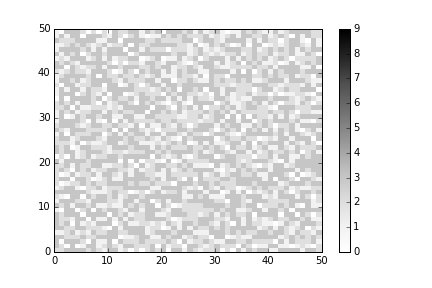
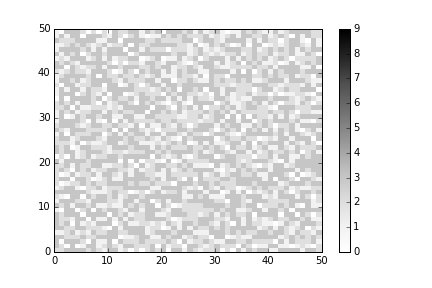
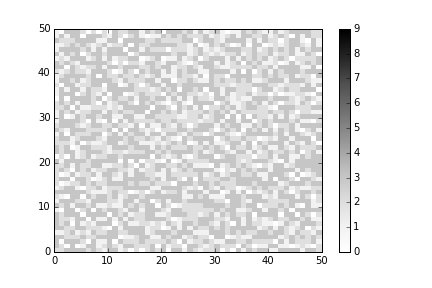
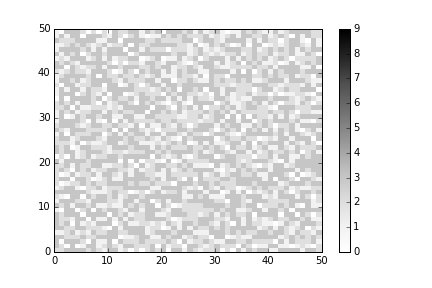
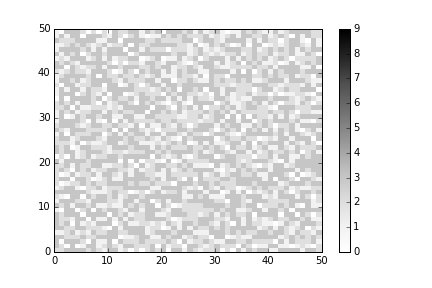
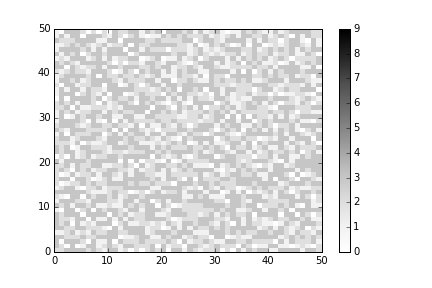

In [260]:
sv.run('random')

In [421]:
k = np.arange(16).reshape(4,4)
p = k
print k
p[0,0]+=1
print k


[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[ 1  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [250]:
k=1
k+= (1>8)
print k


1


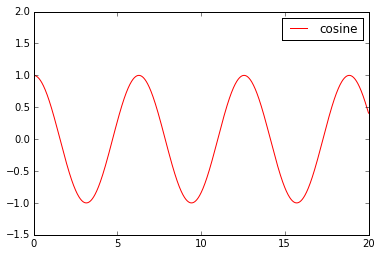

In [477]:
%matplotlib inline
x = np.linspace(0, 20, 1000)
y1 = np.sin(x)
y2 = np.cos(x)


plt.plot(x, y1, '-b', label='sine')
plt.plot(x, y2, '-r', label='cosine')
plt.legend(loc='upper right')
plt.ylim(-1.5, 2.0)
plt.draw()
plt.show()


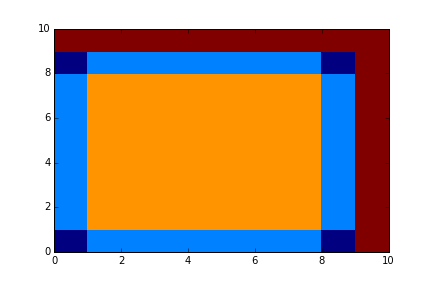
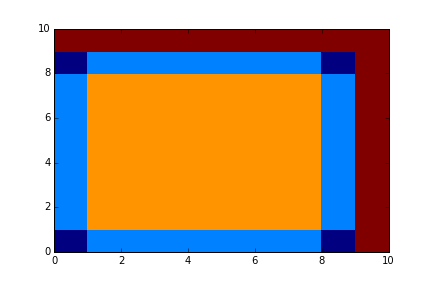
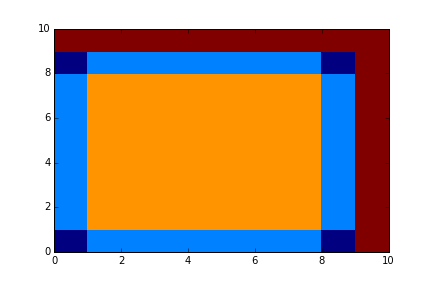
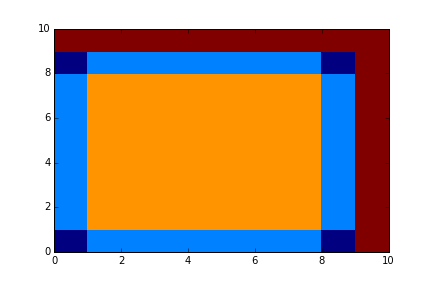
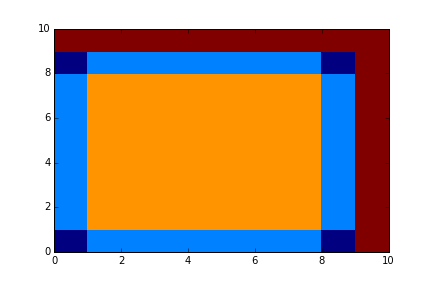
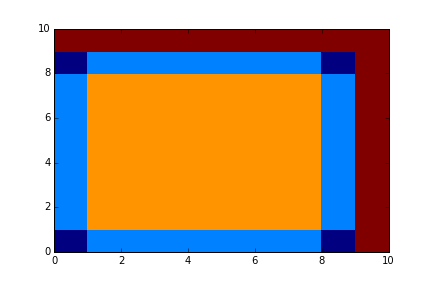
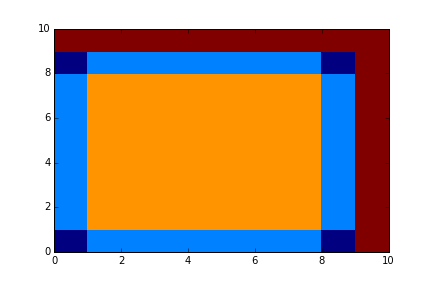
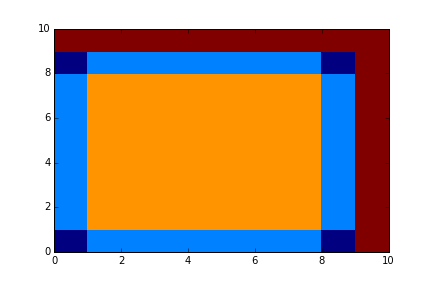
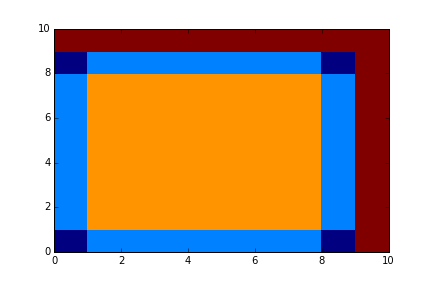
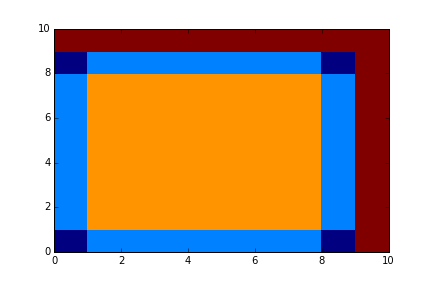
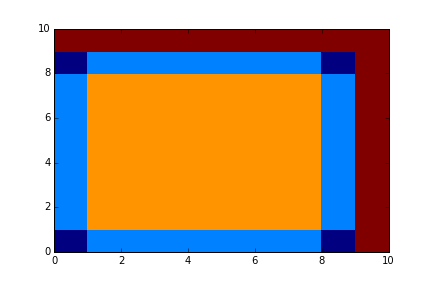
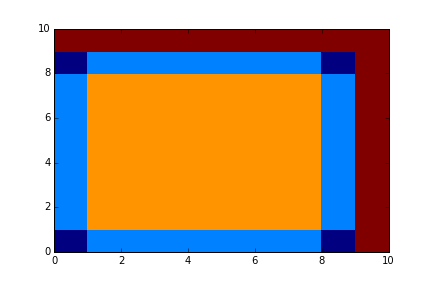
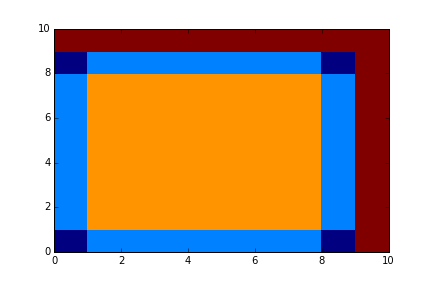
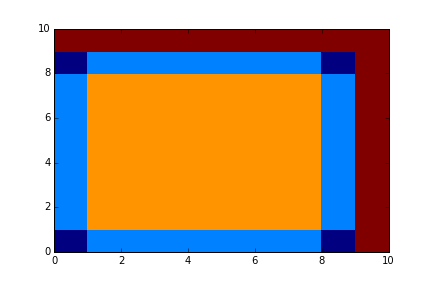
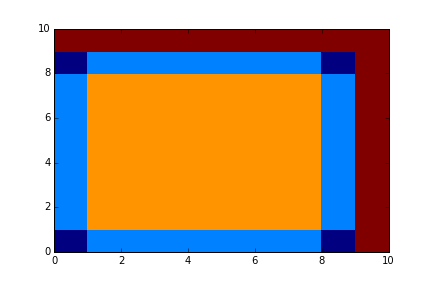
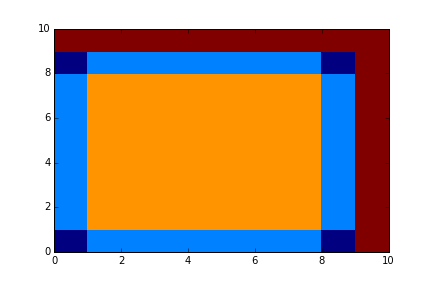
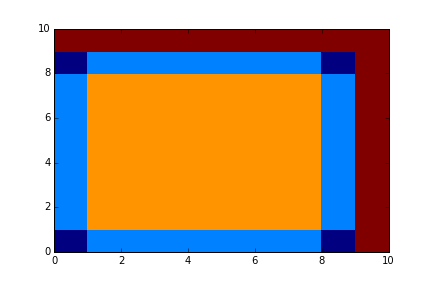
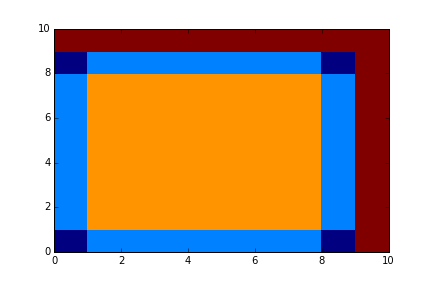
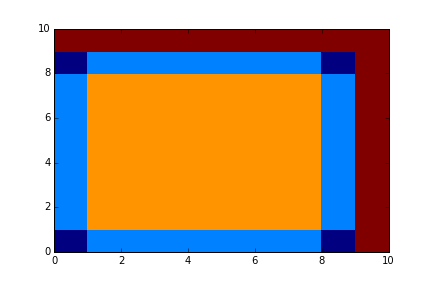
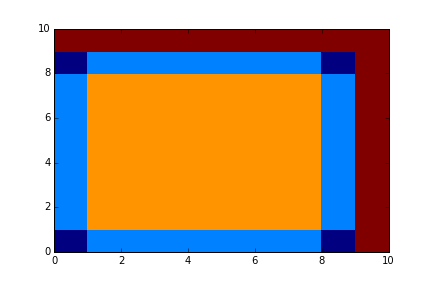

In [216]:
###Do Not Delete:
#sand viewer
sand = SandPile()
a = sand.array
fig, ax = plt.subplots()

def animate(i):
    sand.step()
    a = sand.array
    mesh = ax.pcolormesh(a)
    return mesh,

mesh = ax.pcolormesh(a)
animation.FuncAnimation(fig, 
                        animate,
                        frames=20, 
                        interval=500, 
                        blit=False)